In [31]:
from scipy.optimize import newton_krylov
from pyomo.environ import SolverFactory, SolverManagerFactory
from pyomo.environ import*
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import LpVariable, LpMinimize, LpProblem, lpSum, value,GUROBI, GLPK_CMD
import envs as en
solver = SolverFactory('ipopt')
import os
from pyomo.environ import value
import time

# Optimization with one battery

In [32]:
t1 =  time.time()

# Load data
file_path = r"sampledata4.xlsx"
all_data = pd.read_excel(file_path, sheet_name=None)

# Extract data using Pandas
df_pv = all_data['PPV_capacity']
df_pl = all_data['PL']
df_buysell = all_data['buysell']
df_ess = all_data['ESS-Param']

# Extract date and time columns
date_pv = df_pv.iloc[:, 0].to_numpy().astype(str)
time_pv = df_pv.iloc[:, 1].to_numpy().astype(str)
datetime_pv = pd.to_datetime(pd.Series(date_pv).str.cat(pd.Series(time_pv), sep=' '),dayfirst=True).to_numpy()


date_pl = df_pl.iloc[:, 0].to_numpy().astype(str)
time_pl = df_pl.iloc[:, 1].to_numpy().astype(str)
datetime_pl = pd.to_datetime(pd.Series(date_pl).str.cat(pd.Series(time_pl), sep=' '),dayfirst=True).to_numpy()



date_buysell = df_buysell.iloc[:, 0].to_numpy().astype(str)
time_buysell = df_buysell.iloc[:, 1].to_numpy().astype(str)
datetime_buysell = pd.to_datetime(pd.Series(date_buysell).str.cat(pd.Series(time_buysell), sep=' '),dayfirst=True).to_numpy()

# Extract data as numpy arrays
PPV_capacity_full = df_pv.iloc[:, 2:].to_numpy()
PLoad_full = df_pl.iloc[:, 2:].to_numpy()
Cbuysell_full = df_buysell.iloc[:, 2:].to_numpy()
Cbuy_full = Cbuysell_full[:, 0]
Csell_full = Cbuysell_full[:, 1]
ESSparam = df_ess.iloc[:, 1:].to_numpy()

    
#%%

# Define the date range for the simulation
start_date_str = '01.01.2024 14:00:00'
end_date_str = '17.11.2024 10:30:00'



# print(f"Default Start Date: {start_date_str}")
# print(f"Default End Date: {end_date_str}")

# # Ask user if they want to keep the default or input new dates
# response = input("Do you want to continue with these dates? (yes/no): ").strip().lower()

# if response == 'no':
#     start_date_str = input("Enter new start date (format DD.MM.YYYY HH:MM:SS): ").strip()
#     end_date_str = input("Enter new end date (format DD.MM.YYYY HH:MM:SS): ").strip()

# print(f"Using Start Date: {start_date_str}")
# print(f"Using End Date: {end_date_str}")

start_date = pd.to_datetime(start_date_str, dayfirst=True).to_numpy()
end_date = pd.to_datetime(end_date_str, dayfirst=True).to_numpy()


# Filter data based on the date range using numpy
mask_pv = (datetime_pv >= start_date) & (datetime_pv <= end_date)
mask_pl = (datetime_pl >= start_date) & (datetime_pl <= end_date)
mask_buysell = (datetime_buysell >= start_date) & (datetime_buysell <= end_date)


PPV_capacity = PPV_capacity_full[mask_pl]
PLoad = PLoad_full[mask_pl]
Cbuy = Cbuy_full[mask_buysell]
Csell = Csell_full[mask_buysell]
datetime_sim = datetime_pl[mask_pl]

# Ensure all data has the same number of time steps
num_time_steps = len(PLoad)
if PPV_capacity.shape[0] != num_time_steps or Cbuy.shape[0] != num_time_steps or Csell.shape[0] != num_time_steps:
    raise ValueError("The number of time steps in PLoad, PPV_capacity, Cbuy, and Csell must be the same for the selected date range.")

# Calculate ΔT using numpy
time_diff_seconds = np.diff(datetime_sim).astype('timedelta64[s]').astype(np.float64)
time_diff_minutes = time_diff_seconds / 60
#indices = np.where(time_diff_minutes == 75)[0]
unique_dt_minutes = np.unique(time_diff_minutes)
#%%
# if unique_dt_minutes.size > 1:
#     raise ValueError("ΔT is not constant. The time step between data points must be constant.")
# elif unique_dt_minutes.size == 0:
#     raise ValueError("No time differences calculated. Check input data.")
# else:
#     dt_minutes_value = unique_dt_minutes[0]
ΔT = 0.25  #dt_minutes_value / 60

#%%

# Calculate the number of days
days = ((datetime_sim[-1] - datetime_sim[0]) / np.timedelta64(1, 'D')) + 1
days = int(days)  # optional: convert to integer
# Model Definition
nPlayers = PLoad.shape[1]
Thorizon = num_time_steps

# Initialize SOC
"SOC_end_of_previous_period = {pl: ESSparam[3, pl - 1] for pl in range(1, nPlayers + 1)}"
shared_SOC = ESSparam[3, 0]
detailed_results = []
total_objective_value = 0
update_interval = 2880000 # Update SOC every 288 time steps

#print(f"Solving for the period from {datetime_sim[0]} to {datetime_sim[-1]}...")

#%%
################## Indexes ####################################################################################

#for day in range(days):  # Loop over days 0,1,2,..., days-1
    
for chunk_start_time in range(0, Thorizon+1, update_interval):
    
    chunk_end_time = min(chunk_start_time + update_interval, Thorizon)
    
    print(f"Solving for time steps: {chunk_start_time} to {chunk_end_time}")
    
    
  
    
    model = ConcreteModel()  # Use ConcreteModel

    # Define sets
    model.PL = RangeSet(nPlayers)
    model.T = RangeSet(chunk_end_time - chunk_start_time)
    model.ESS1 = RangeSet(ESSparam.shape[0]) #nb de ligne

    # Define parameters using numpy arrays
    PLoad_chunk = PLoad[chunk_start_time:chunk_end_time]
    PPV_capacity_chunk = PPV_capacity[chunk_start_time:chunk_end_time]
    Cbuy_chunk = Cbuy[chunk_start_time:chunk_end_time]
    Csell_chunk = Csell[chunk_start_time:chunk_end_time]
    datetime_chunk = datetime_sim[chunk_start_time:chunk_end_time]
    
    
    model.PLs=Param(model.T,model.PL,initialize=lambda model,r,c:PLoad_chunk[r-1,c-1], within=Reals)
    model.PPV_capacitys=Param(model.T,model.PL,initialize=lambda model,r,c:PPV_capacity_chunk[r-1,c-1], within=Reals)
    model.Cbuys=Param(model.T,initialize=lambda model,r:Cbuy_chunk[r-1], within=Reals)
    model.Csells=Param(model.T,initialize=lambda model,r:Csell_chunk[r-1], within=Reals)
    "model.ESSparams=Param(model.ESS1,model.PL,initialize=lambda model,r,c:ESSparam[r-1,c-1], within=Reals)"
    "model.ESSparams = Param(model.ESS1, initialize=lambda model, r: ESSparam[r-1], within=Reals)"
    model.ESSparams = Param(model.ESS1, initialize=lambda model, r: ESSparam[r-1, 0], within=Reals)


    # Variables
    """
    model.P_ESS_s = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_ESS_ch = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_ESS_dch = Var(model.PL, model.T, within=NonNegativeReals)
    model.I_ESS_ch = Var(model.PL, model.T, within=Binary)
    model.I_ESS_dch = Var(model.PL, model.T, within=Binary)
    """
    model.P_ESS_s = Var(model.T, within=NonNegativeReals)
    model.P_ESS_ch = Var(model.T, within=NonNegativeReals)
    model.P_ESS_dch = Var(model.T, within=NonNegativeReals)
    model.I_ESS_ch = Var(model.T, within=Binary)
    model.I_ESS_dch = Var(model.T, within=Binary)

    model.P_buy = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_sell = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_sell_grid = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_buy_grid = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_peer = Var(model.PL, model.PL, model.T, within=NonNegativeReals)
    model.I_buy= Var(model.PL, model.T, within=Binary)
    model.I_sell = Var(model.PL, model.T, within=Binary)
    
    
    
    
    #    model.P_PV = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for charging battery
    #    model.P_PV_load = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for direct load consumption



    # Constraints
    """
    def SocESS_rule(model, PL, T):
        if T == 1:
            prev_SOC = SOC_end_of_previous_period[PL]
            return model.P_ESS_s[PL, T] == prev_SOC + ΔT * (model.ESSparams[model.ESS1.ord(1), PL] * model.P_ESS_ch[PL, T] - model.P_ESS_dch[PL, T] /model.ESSparams[model.ESS1.ord(1), PL])
        else:
            return model.P_ESS_s[PL, T] == (model.P_ESS_s[PL, T - 1]+ ΔT * (model.ESSparams[model.ESS1.ord(1), PL] * model.P_ESS_ch[PL, T]- model.P_ESS_dch[PL, T] / model.ESSparams[model.ESS1.ord(1), PL]))

    model.c_SOC = Constraint(model.PL, model.T, rule=SocESS_rule)
    """
    # Define the constraint rule for the shared battery SOC
    def SocESS_rule(model, T):
        if T == 1:
            # Use the shared SOC for the initial state
            prev_SOC = shared_SOC
            return model.P_ESS_s[T] == prev_SOC + ΔT * (
                model.ESSparams[model.ESS1.ord(1)] * model.P_ESS_ch[T] - model.P_ESS_dch[T] /model.ESSparams[model.ESS1.ord(1)])
        else:
            return model.P_ESS_s[T] == (model.P_ESS_s[T - 1]+ ΔT * (model.ESSparams[model.ESS1.ord(1)] * model.P_ESS_ch[T]- model.P_ESS_dch[T] / model.ESSparams[model.ESS1.ord(1)]))

    # Apply the constraint to the model
    model.c_SOC = Constraint(model.T, rule=SocESS_rule)

    """
    def CapacitylimitESS1_rule(model, PL, T):
        return model.P_ESS_s[PL, T] <= model.ESSparams[model.ESS1.ord(3), PL]

    model.c92 = Constraint(model.PL, model.T, rule=CapacitylimitESS1_rule)
    """
    
    # Define the constraint rule for the shared battery capacity limit
    def CapacitylimitESS1_rule(model, T):
        return model.P_ESS_s[T] <= model.ESSparams[model.ESS1.ord(3)]

    # Apply the constraint to the model
    model.c92 = Constraint(model.T, rule=CapacitylimitESS1_rule)

    """
    def chargeESS1_rule(model, PL, T):
        return model.P_ESS_ch[PL, T] <= model.ESSparams[model.ESS1.ord(2), PL] * model.ESSparams[
            model.ESS1.ord(3), PL] * model.I_ESS_ch[PL, T]

    model.c42 = Constraint(model.PL, model.T, rule=chargeESS1_rule)
    """
    # Define the constraint rule for the shared battery charge limit
    def chargeESS1_rule(model, T):
        return model.P_ESS_ch[T] <= model.ESSparams[model.ESS1.ord(2)] * model.ESSparams[model.ESS1.ord(3)] * model.I_ESS_ch[T]

    # Apply the constraint to the model
    model.c42 = Constraint(model.T, rule=chargeESS1_rule)

        
    """
    def dischargeESS1_rule(model, PL, T):
        return model.P_ESS_dch[PL, T] <= model.ESSparams[model.ESS1.ord(2), PL] * model.ESSparams[
            model.ESS1.ord(3), PL] * model.I_ESS_dch[PL, T]

    model.c43 = Constraint(model.PL, model.T, rule=dischargeESS1_rule)
    """

    # Define the constraint rule for the shared battery discharge limit
    def dischargeESS1_rule(model, T):
        return model.P_ESS_dch[T] <= model.ESSparams[model.ESS1.ord(2)] * model.ESSparams[model.ESS1.ord(3)] * model.I_ESS_dch[T]

    # Apply the constraint to the model
    model.c43 = Constraint(model.T, rule=dischargeESS1_rule)

    """
    def chargedischargeESS_rule(model, PL, T):
        return model.I_ESS_ch[PL, T] + model.I_ESS_dch[PL, T] <= 1

    model.c44 = Constraint(model.PL, model.T, rule=chargedischargeESS_rule)
    """
    # Define the constraint rule for the shared battery charge/discharge
    def chargedischargeESS_rule(model, T):
        return model.I_ESS_ch[T] + model.I_ESS_dch[T] <= 1

    # Apply the constraint to the model
    model.c44 = Constraint(model.T, rule=chargedischargeESS_rule)

    
    # def chargedischargelimit(model,PL):
    
    #         return sum( model.I_ESS_ch[PL,T]+model.I_ESS_dch[PL,T] for T in model.T) <=8
    
    # model.c45=Constraint(model.PL,rule=chargedischargelimit) #  ESS constraints


    """
    def load_balance_rule(model, PL, T):
        return model.PLs[T, PL] + model.P_ESS_ch[PL, T] == model.PPV_capacitys[T, PL] + model.P_buy_grid[PL, T] - \
           model.P_sell_grid[PL, T] + model.P_ESS_dch[PL, T] + sum(
            model.P_peer[PL2, PL, T] - model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.c_balance = Constraint(model.PL, model.T, rule=load_balance_rule)
    """
    def load_balance_rule(model, PL, T):
        return model.PLs[T, PL] == model.PPV_capacitys[T, PL] + model.P_buy_grid[PL, T] - \
           model.P_sell_grid[PL, T] + model.P_ESS_dch[T] - model.P_ESS_ch[T] + \
           sum(model.P_peer[PL2, PL, T] - model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.c_balance = Constraint(model.PL, model.T, rule=load_balance_rule)

    
    
    
    def peer_flow_origin_rule(model, t):
        total_peer_in = sum(model.P_peer[pl2, pl, t] for pl in model.PL for pl2 in model.PL if pl2 != pl)
        total_peer_out = sum(model.P_peer[pl, pl2, t] for pl in model.PL for pl2 in model.PL if pl2 != pl)
        return total_peer_in == total_peer_out
    model.peer_origin = Constraint(model.T, rule=peer_flow_origin_rule)

    
     
    
    
    
    def peer_transfer_limit_rule(model, PL, T):
        return sum(model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL) <= np.maximum(0,
                                                                                 model.PPV_capacitys[T, PL] -
                                                                                 model.PLs[T, PL])

    model.c_peer = Constraint(model.PL, model.T, rule=peer_transfer_limit_rule)
    
#    def PV_utilization(model, PL, T):
#        return model.P_PV_ESS[PL, T] + model.P_PV_load[PL, T] == model.PPV_capacitys[T, PL]

#    model.c_PV_utilization = Constraint(model.PL, model.T, rule=PV_utilization)
#    def chargeESS2(model, PL, T):
#        return model.P_ESS_ch[PL, T] == model.P_PV_ESS[PL, T]  # Battery charges only from PV

#    model.c_ESS_PV_only = Constraint(model.PL, model.T, rule=chargeESS2)


    """
    def enforce_battery_soc_limit_rule(model, PL, T):
        return model.P_ESS_s[PL, T]  >= model.ESSparams[model.ESS1.ord(4), PL]

    model.c21 = Constraint(model.PL, model.T, rule=enforce_battery_soc_limit_rule)
    """
    
    # Define the constraint rule for the shared battery SOC limit
    def enforce_battery_soc_limit_rule(model, T):
        return model.P_ESS_s[T] >= model.ESSparams[model.ESS1.ord(4)]

    # Apply the constraint to the model
    model.c21 = Constraint(model.T, rule=enforce_battery_soc_limit_rule)



    def Pbuy11_rule(model, PL, T):
        return model.P_buy[PL, T] <= 200* model.I_buy[PL, T]

    model.c22 = Constraint(model.PL, model.T, rule=Pbuy11_rule)



    def Psell_balance(model, PL, T):
        return model.P_sell[PL, T] == model.P_sell_grid[PL, T]+sum(model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.psellbalance = Constraint(model.PL, model.T, rule=Psell_balance)


    def Pbuy_balance(model, PL, T):
        return model.P_buy[PL, T] == model.P_buy_grid[PL, T]+sum(model.P_peer[PL2, PL, T] for PL2 in model.PL if PL2 != PL)

    model.pbuybalance = Constraint(model.PL, model.T, rule=Pbuy_balance)



    def Psell11_rule(model, PL, T):
        return model.P_sell[PL, T] <= 100* model.I_sell[PL, T]

    model.c23 = Constraint(model.PL, model.T, rule=Psell11_rule)
    
    
    def Psellbuy(model, PL, T):
        return model.I_sell[PL, T]+model.I_buy[PL, T] <= 1

    model.csellbuy = Constraint(model.PL, model.T, rule=Psellbuy) 
    
    
    



    # Objective Function
    def rule_OF(model):
        return sum((model.Cbuys[t] * model.P_buy_grid[PL, t]- model.Csells[t] * model.P_sell_grid[PL, t])
            for t in model.T
            for PL in model.PL
        )

    model.Objective = Objective(rule=rule_OF, sense=minimize)
    
#      model.c_ESS_PV_only.deactivate()
    
    
    

    opt = SolverFactory('gurobi')
    #opt.options['TimeLimit'] = 100000  # Set a time limit of 300 seconds
    #opt.options['MIPGap'] = 0.01    # Set a MIP gap tolerance of 1%
    instance=model.create_instance() 
    # Solve the model

    opt.options['Threads'] = 28       
    opt.options['TimeLimit'] = 60000   # Set a time limit of 600 seconds (10 minutes)
    #    opt.options['MIPGap'] = 0.00005     # Allow 1% optimality gap
    #    opt.options['Heuristics'] = 0.3
    # Solve and measure time
    
    
    

    results = opt.solve(instance)
    results.write()

    total_objective_value += value(instance.Objective)
    
    # Prepare results for DataFrame 
    chunk_results_list = []
    # for t_index, t in enumerate(model.T):
    #     for pl_index, pl in enumerate(model.PL):
    #         chunk_results_list.append({
    #             "DateTime": datetime_chunk[t_index],
    #             "Time_Step": chunk_start_time + t_index + 1,  # Corrected time step
    #             "Prosumer": pl,
    #             "P_buy": value(instance.P_buy[pl, t]),
    #             "P_sell": value(instance.P_sell[pl, t]),
    #             "SOC": value(instance.P_ESS_s[pl, t]),
    #             "P_ESS_ch": value(instance.P_ESS_ch[pl, t]),
    #             "P_ESS_dch": value(instance.P_ESS_dch[pl, t]),
    #             "P_PV": value(instance.PPV_capacitys[t, pl]),
    #             "P_Peer_out": sum(value(instance.P_peer[pl, pl2, t]) for pl2 in model.PL if pl2 != pl),
    #             "P_Peer_in": sum(value(instance.P_peer[pl2, pl, t]) for pl2 in model.PL if pl2 != pl),
    #             "P_Load": value(instance.PLs[t, pl])
    #         })
    
    for t_index, t in enumerate(model.T):
        dt = pd.to_datetime(datetime_chunk[t_index])  # Convert to pandas Timestamp

        chunk_row = {
            "DateTime": dt,
            #"Date": dt.date(),  
            "Time_Step": chunk_start_time + t_index + 1,
        }
    
        for pl in model.PL:
            chunk_row[f"model.P_buy_grid[{pl}]"] = value(instance.P_buy_grid[pl, t])
            chunk_row[f"model.P_sell_grid[{pl}]"] = value(instance.P_sell_grid[pl, t])
            """
            chunk_row[f"SOC[{pl}]"] = value(instance.P_ESS_s[pl, t])
            """
            chunk_row["SOC"] = value(instance.P_ESS_s[t])
            """
            chunk_row[f"P_ESS_ch[{pl}]"] = value(instance.P_ESS_ch[pl, t])
            chunk_row[f"P_ESS_dch[{pl}]"] = value(instance.P_ESS_dch[pl, t])
            """
            chunk_row["P_ESS_ch"] = value(instance.P_ESS_ch[t])
            chunk_row["P_ESS_dch"] = value(instance.P_ESS_dch[t])
            
            chunk_row[f"P_PV[{pl}]"] = value(instance.PPV_capacitys[t, pl])
            chunk_row[f"P_Peer_out[{pl}]"] = sum(value(instance.P_peer[pl, pl2, t]) for pl2 in model.PL if pl2 != pl)
            chunk_row[f"P_Peer_in[{pl}]"] = sum(value(instance.P_peer[pl2, pl, t]) for pl2 in model.PL if pl2 != pl)
            chunk_row[f"P_Load[{pl}]"] = value(instance.PLs[t, pl])
    
        chunk_results_list.append(chunk_row)

    
    
    
    
    
    
    
    
    # Convert chunk results to DataFrame and append
    chunk_results_df = pd.DataFrame(chunk_results_list)
    detailed_results.append(chunk_results_df)
#%%
    # Update SOC_end_of_previous_period 
    #SOC_end_of_day.update({(PL, day): value(instance.P_ESS_s[PL, Thorizon]) for PL in model.PL})
    """
    SOC_end_of_previous_period.update( {pl: value(instance.P_ESS_s[pl, model.T.last()]) for pl in model.PL})
    print(f"SOC updated at time step: {chunk_end_time}")
    print(SOC_end_of_previous_period)
    """
    
    # Update shared_SOC
    shared_SOC = value(instance.P_ESS_s[model.T.last()])
    print(f"SOC updated at time step: {chunk_end_time}")
    print(shared_SOC)

    
# Concatenate all chunk results
detailed_results_df = pd.concat(detailed_results, ignore_index=True)

# Convert results to a DataFrame and save to Excel
detailed_results_path = r"detailed_results.xlsx"
detailed_results_df.to_excel(detailed_results_path, index=False)

print(f"Detailed results for the period saved to: {detailed_results_path}")
print(f"Overall objective function value for the period: {total_objective_value:.2f}")

t2 = time.time()

print(f'Total running time= {t2-t1}' )

Solving for time steps: 0 to 30799
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 42571375.45155599
  Upper bound: 42571375.45155615
  Number of objectives: 1
  Number of constraints: 1293558
  Number of variables: 1693946
  Number of binary variables: 369588
  Number of integer variables: 369588
  Number of continuous variables: 1324358
  Number of nonzeros: 5605417
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Ter

In [33]:
print(detailed_results_df.columns)


Index(['DateTime', 'Time_Step', 'model.P_buy_grid[1]', 'model.P_sell_grid[1]',
       'SOC', 'P_ESS_ch', 'P_ESS_dch', 'P_PV[1]', 'P_Peer_out[1]',
       'P_Peer_in[1]', 'P_Load[1]', 'model.P_buy_grid[2]',
       'model.P_sell_grid[2]', 'P_PV[2]', 'P_Peer_out[2]', 'P_Peer_in[2]',
       'P_Load[2]', 'model.P_buy_grid[3]', 'model.P_sell_grid[3]', 'P_PV[3]',
       'P_Peer_out[3]', 'P_Peer_in[3]', 'P_Load[3]', 'model.P_buy_grid[4]',
       'model.P_sell_grid[4]', 'P_PV[4]', 'P_Peer_out[4]', 'P_Peer_in[4]',
       'P_Load[4]', 'model.P_buy_grid[5]', 'model.P_sell_grid[5]', 'P_PV[5]',
       'P_Peer_out[5]', 'P_Peer_in[5]', 'P_Load[5]'],
      dtype='object')


# Energy Data Analysis

## 1. Preprocess the data
- Rename columns according to the mapping table (makes them more readable).  
- Convert `DateTime` into a time index.  

## 2. Useful KPIs
- **Total energy purchased from the grid** → sum of `EnergyPurchased`.  
- **Total energy sold to the grid** → sum of `EnergySold`.  
- **Solar self-consumption (%)** = (`EnergyForDemand` + `EnergyForBattery`) ÷ `MaxSolarProduction`.  
- **Grid independence (%)** = 1 - (`EnergyPurchased` ÷ `UserDemand`).  
- **Peer-to-peer exchange** → difference between `EnergySent` and `EnergyReceived`.  
- **Final battery charge level** (`FinalChargeLevel`).  

## 3. Possible Plots
### 📈 Time series plots
- `UserDemand`, `MaxSolarProduction`, `BatteryCharge`, `BatteryDischarge` over time.  
- Battery `ChargeLevel` (SOC) as a line chart.  

### 📊 Aggregated bar charts
- Total energy purchased vs. sold per user.  
- Demand vs. production comparison.  

### 🔄 Stacked area plots
- How the demand (`UserDemand`) is covered: solar, battery, or grid.  

### 🟢 KPI visualizations (gauge or box)
- Self-consumption (%)  
- Grid independence (%)  
- Battery efficiency  


## Prosumer 1 Plots:

Grid independence: 20.75%


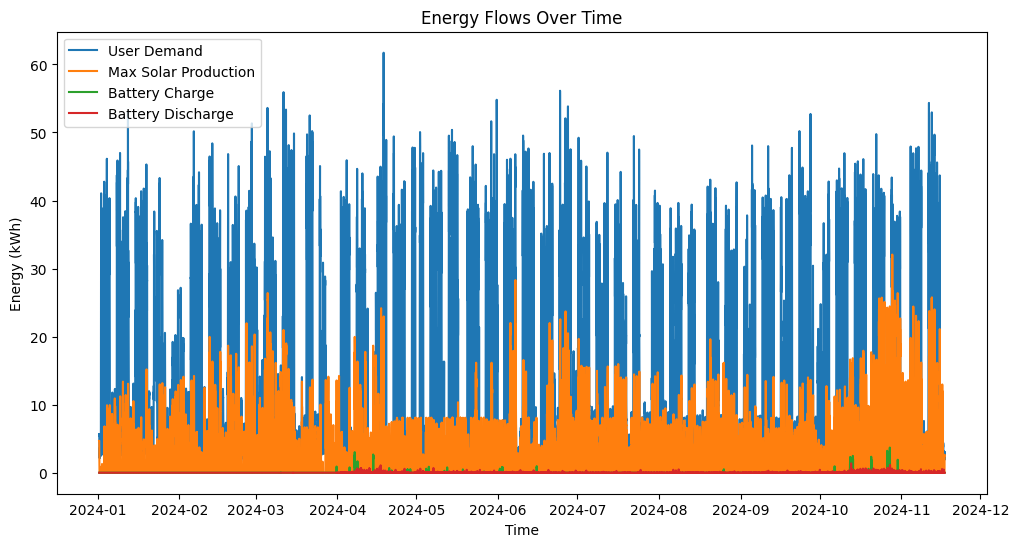

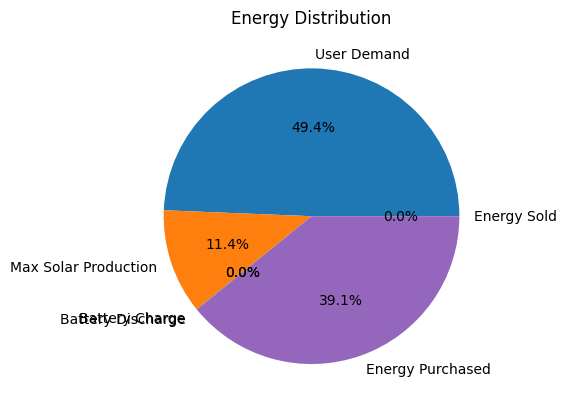

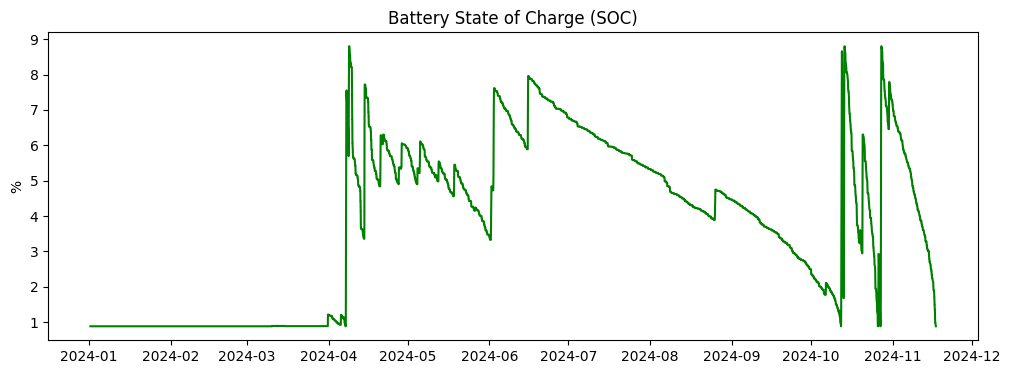

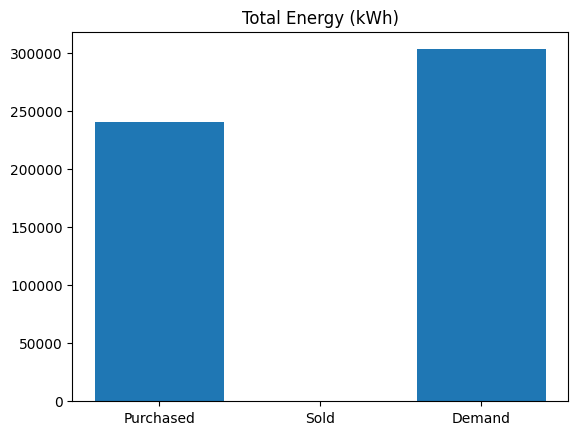

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prepare ---
file_path = r"detailed_results.xlsx"
df2 = pd.read_excel(file_path, sheet_name=None)
df2 = pd.concat(df2.values(), ignore_index=True)

df2["DateTime"] = pd.to_datetime(df2["DateTime"])
df2.set_index("DateTime", inplace=True)


df2.rename(columns={
    "P_Load[1]": "UserDemand_1",
    "P_PV[1]": "MaxSolarProduction_1",
    "P_ESS_ch": "BatteryCharge",
    "P_ESS_dch": "BatteryDischarge",
    "SOC": "ChargeLevel",
    "model.P_buy_grid[1]": "EnergyPurchased_1",
    "model.P_sell_grid[1]": "EnergySold_1"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_1"].sum()
total_purchased = df2["EnergyPurchased_1"].sum()
total_sold = df2["EnergySold_1"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_1"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_1"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_1"], df2["MaxSolarProduction_1"], df2["BatteryCharge"], df2["BatteryDischarge"], df2["EnergyPurchased_1"], df2["EnergySold_1"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()

# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()


# Prosumer 2 Plots

Grid independence: 31.10%


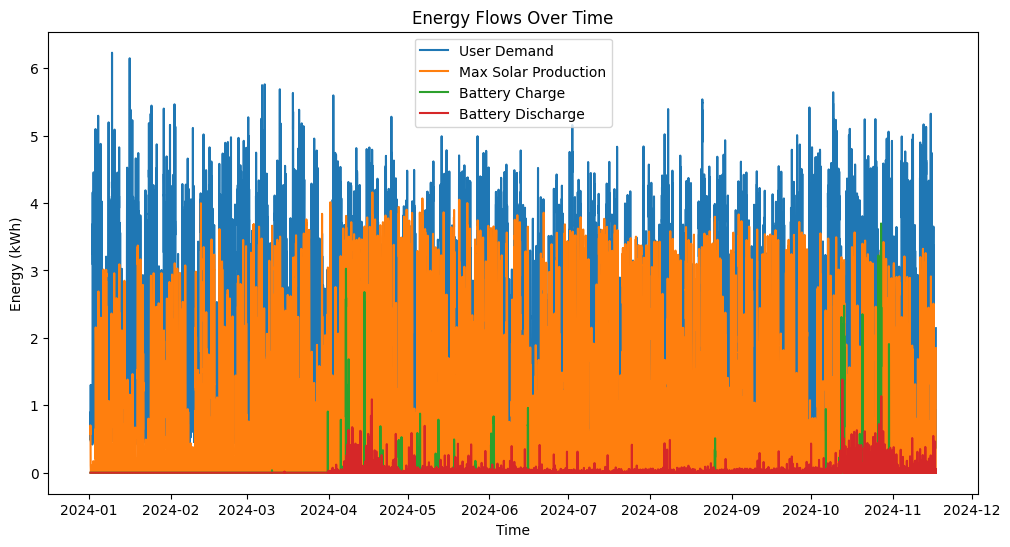

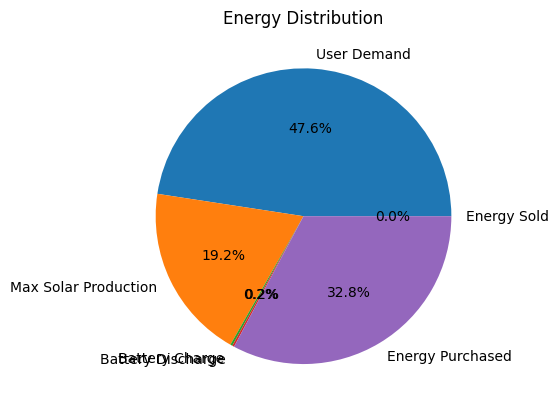

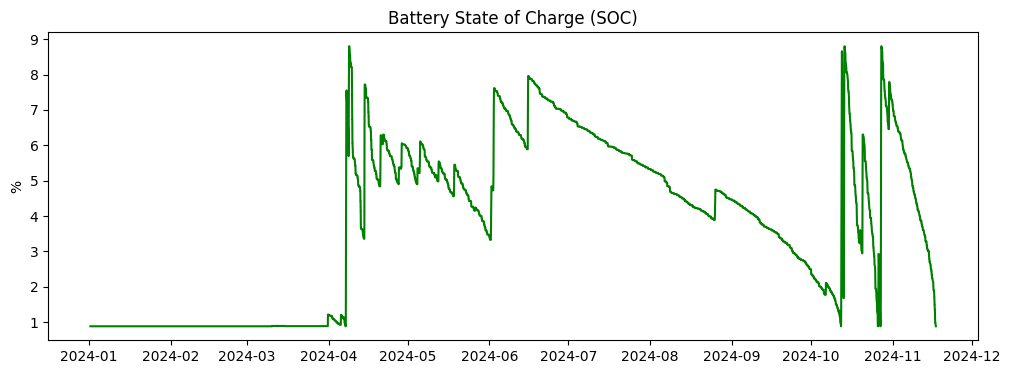

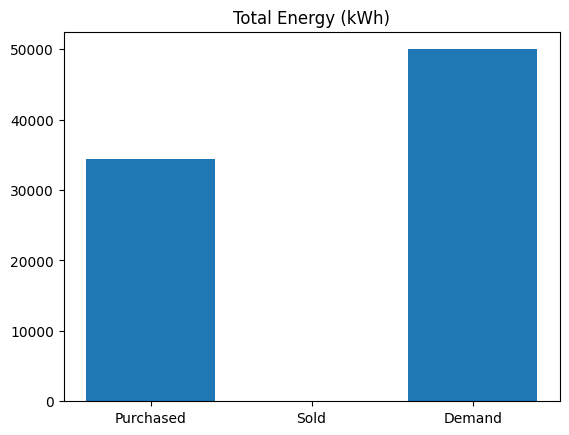

In [ ]:
df2.rename(columns={
    "P_Load[2]": "UserDemand_2",
    "P_PV[2]": "MaxSolarProduction_2",
    "P_ESS_ch": "BatteryCharge",
    "P_ESS_dch": "BatteryDischarge",
    "SOC": "ChargeLevel",
    "model.P_buy_grid[2]": "EnergyPurchased_2",
    "model.P_sell_grid[2]": "EnergySold_2"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_2"].sum()
total_purchased = df2["EnergyPurchased_2"].sum()
total_sold = df2["EnergySold_2"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_2"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_2"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_2"], df2["MaxSolarProduction_2"], df2["BatteryCharge"], df2["BatteryDischarge"], df2["EnergyPurchased_2"], df2["EnergySold_2"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()


# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()

Grid independence: 8.01%


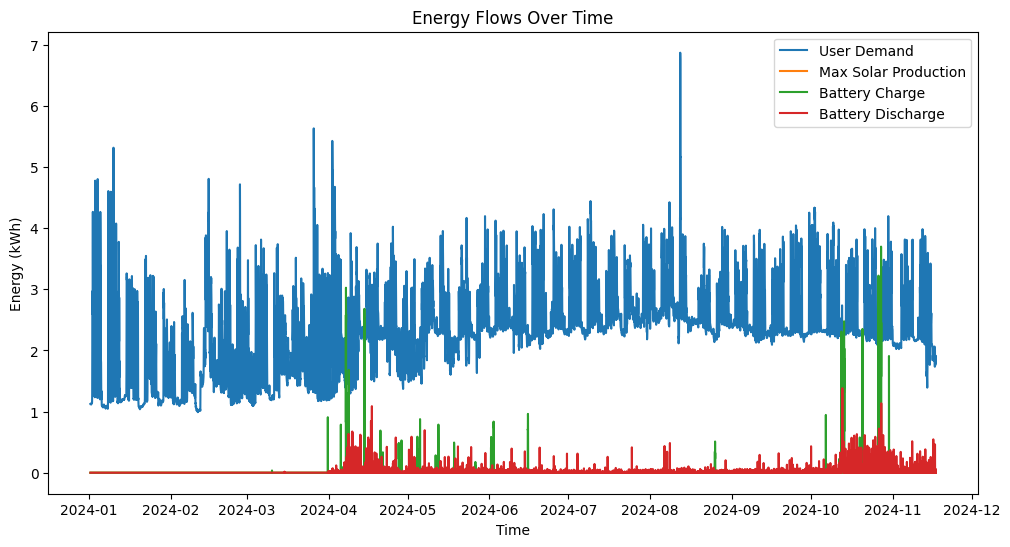

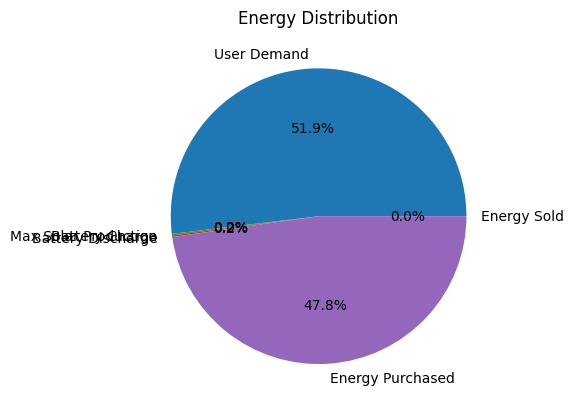

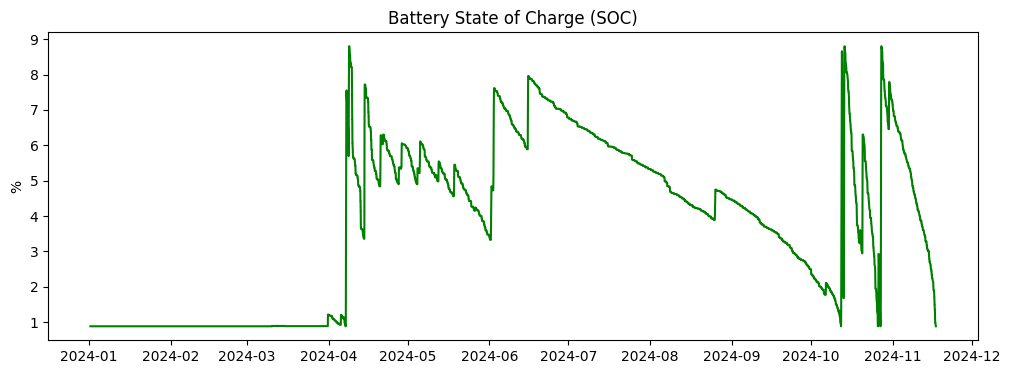

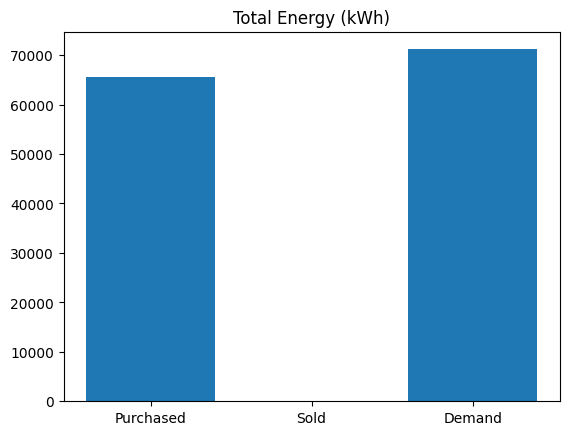

In [ ]:
df2.rename(columns={
    "P_Load[3]": "UserDemand_3",
    "P_PV[3]": "MaxSolarProduction_3",
    "P_ESS_ch": "BatteryCharge",
    "P_ESS_dch": "BatteryDischarge",
    "SOC": "ChargeLevel",
    "model.P_buy_grid[3]": "EnergyPurchased_3",
    "model.P_sell_grid[3]": "EnergySold_3"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_3"].sum()
total_purchased = df2["EnergyPurchased_3"].sum()
total_sold = df2["EnergySold_3"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_3"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_3"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_3"], df2["MaxSolarProduction_3"], df2["BatteryCharge"], df2["BatteryDischarge"], df2["EnergyPurchased_3"], df2["EnergySold_3"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()


# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()

## Prosumer 4 plots

Grid independence: 0.78%


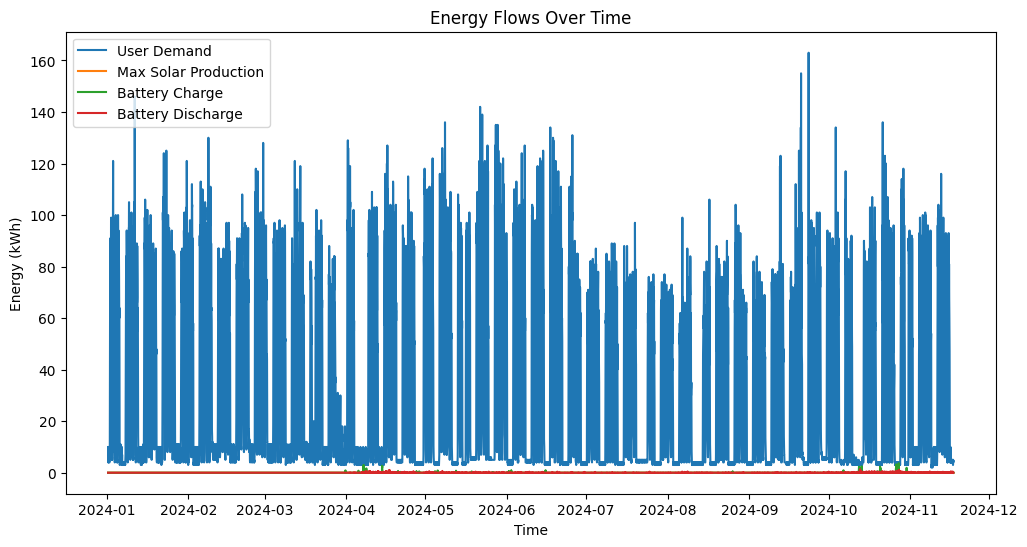

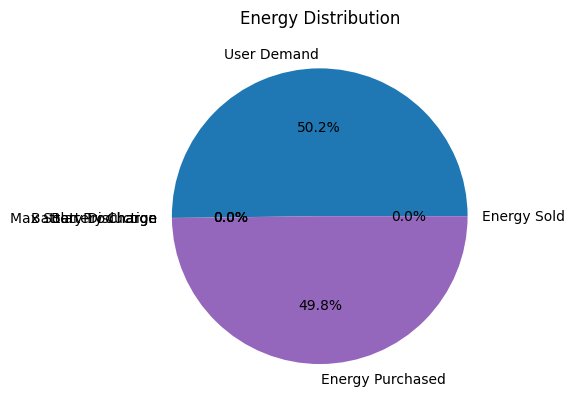

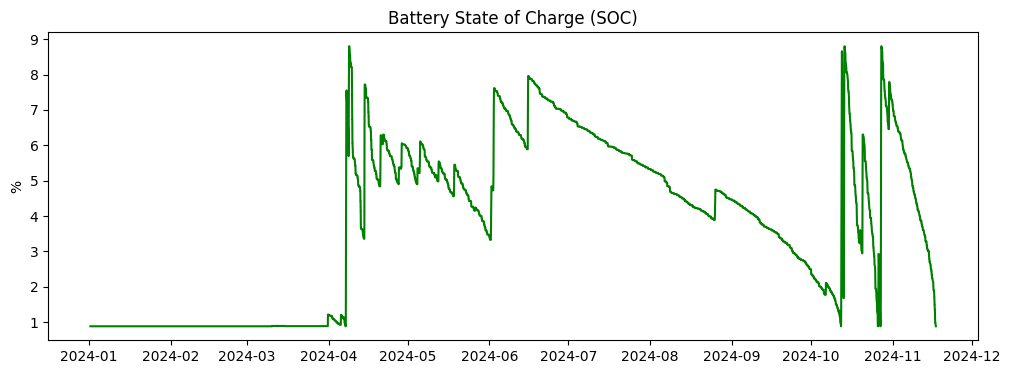

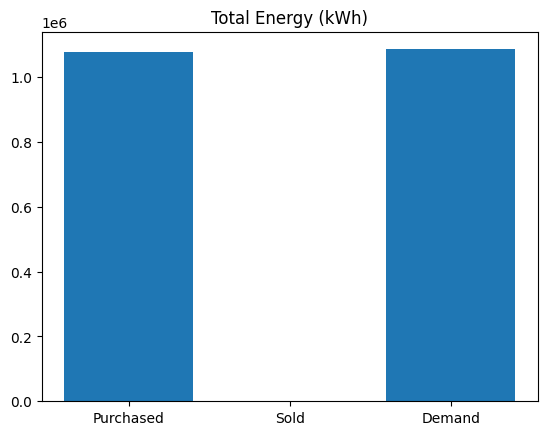

In [ ]:
df2.rename(columns={
    "P_Load[4]": "UserDemand_4",
    "P_PV[4]": "MaxSolarProduction_4",
    "P_ESS_ch": "BatteryCharge",
    "P_ESS_dch": "BatteryDischarge",
    "SOC": "ChargeLevel",
    "model.P_buy_grid[4]": "EnergyPurchased_4",
    "model.P_sell_grid[4]": "EnergySold_4"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_4"].sum()
total_purchased = df2["EnergyPurchased_4"].sum()
total_sold = df2["EnergySold_4"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_4"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_4"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_4"], df2["MaxSolarProduction_4"], df2["BatteryCharge"], df2["BatteryDischarge"], df2["EnergyPurchased_4"], df2["EnergySold_4"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()


# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()

## Prosumer 5 plots

Grid independence: 54.57%


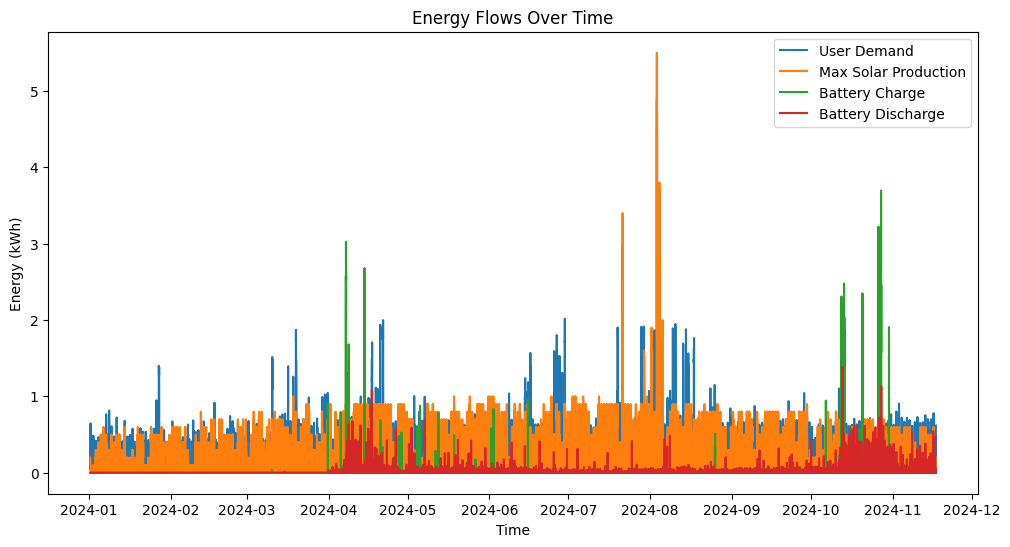

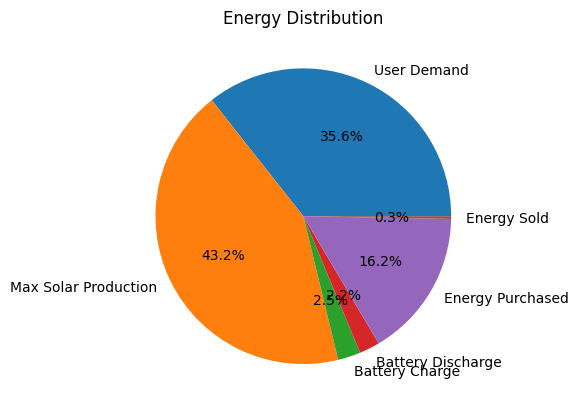

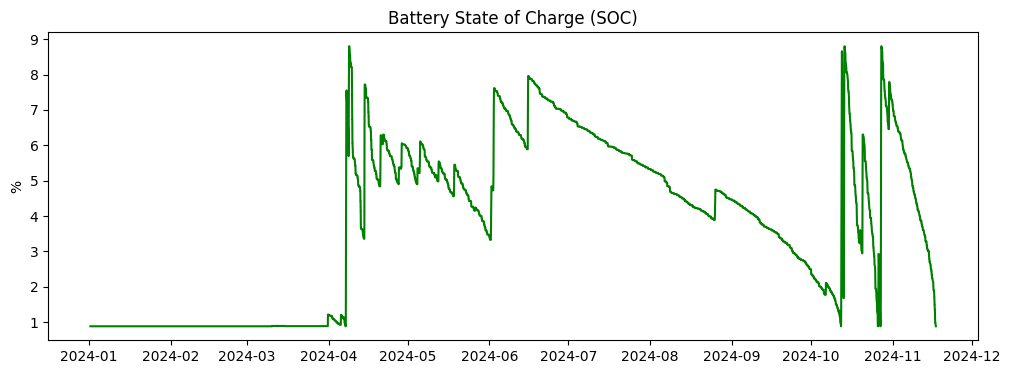

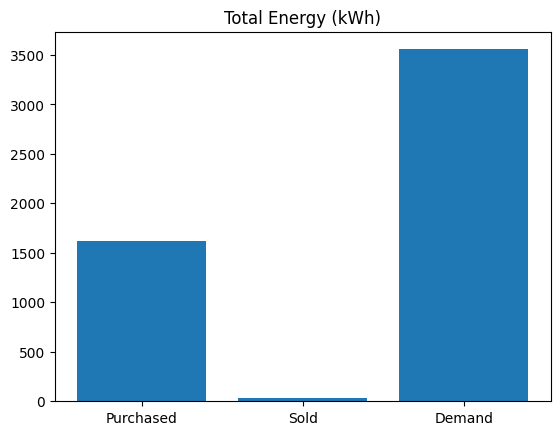

In [ ]:
df2.rename(columns={
    "P_Load[5]": "UserDemand_5",
    "P_PV[5]": "MaxSolarProduction_5",
    "P_ESS_ch": "BatteryCharge",
    "P_ESS_dch": "BatteryDischarge",
    "SOC": "ChargeLevel",
    "model.P_buy_grid[5]": "EnergyPurchased_5",
    "model.P_sell_grid[5]": "EnergySold_5"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_5"].sum()
total_purchased = df2["EnergyPurchased_5"].sum()
total_sold = df2["EnergySold_5"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_5"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_5"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_5"], df2["MaxSolarProduction_5"], df2["BatteryCharge"], df2["BatteryDischarge"], df2["EnergyPurchased_5"], df2["EnergySold_5"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()


# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()

## Community plots 


=== KPIs by prosumer ===
          Demand  SolarProduction  Purchased  Sold  NetGrid  Independence  \
Prosumer                                                                    
1            0.0              0.0        0.0   0.0      0.0           0.0   
2            0.0              0.0        0.0   0.0      0.0           0.0   
3            0.0              0.0        0.0   0.0      0.0           0.0   
4            0.0              0.0        0.0   0.0      0.0           0.0   
5            0.0              0.0        0.0   0.0      0.0           0.0   

               PeerIn      PeerOut  PeerBalance  
Prosumer                                         
1          203.616433  7563.247525  7359.631091  
2          297.729977  4881.517000  4583.787023  
3         5722.341705     0.000000 -5722.341705  
4         8533.197465     0.000000 -8533.197465  
5          258.942237  2571.063293  2312.121056  

⚠️ Missing columns by prosumer (treated as 0 in KPIs):
  Prosumer 1: load, pv, buy,

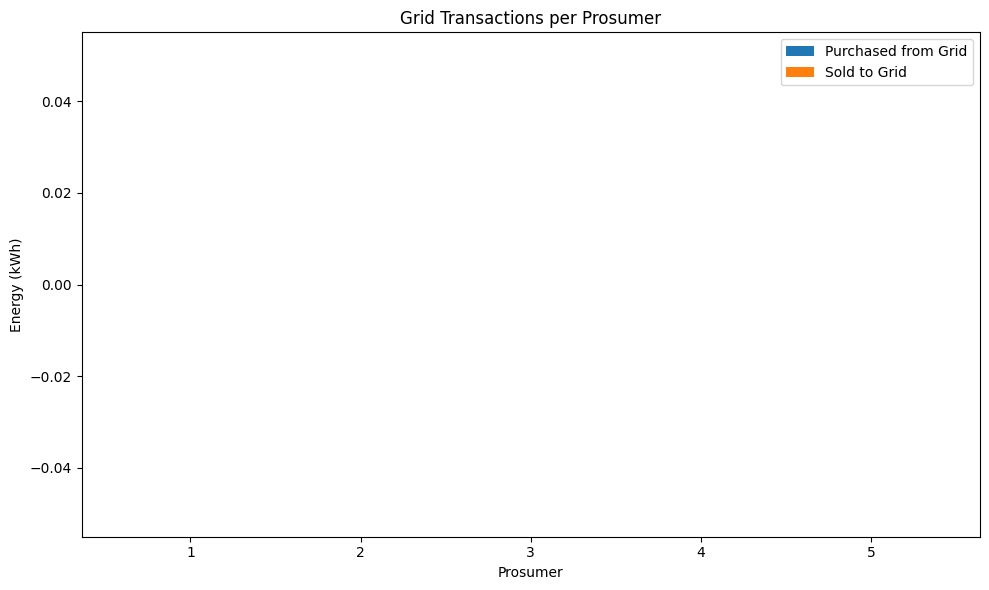

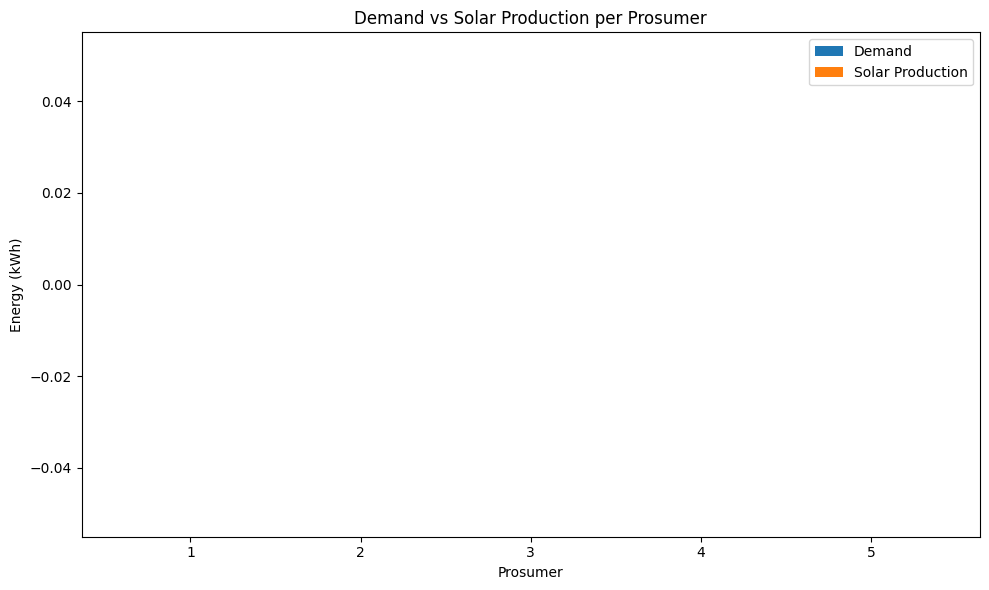

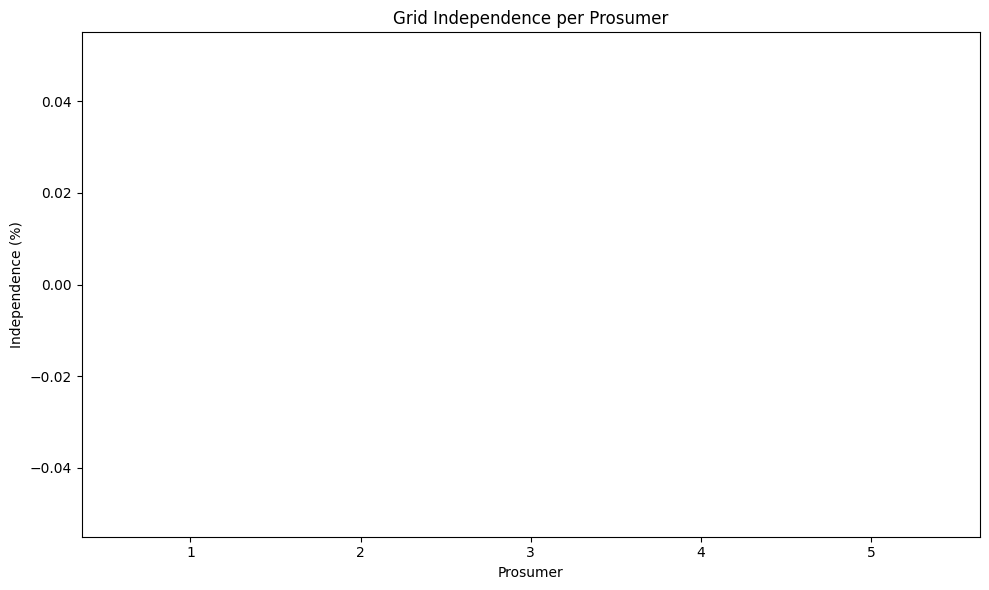

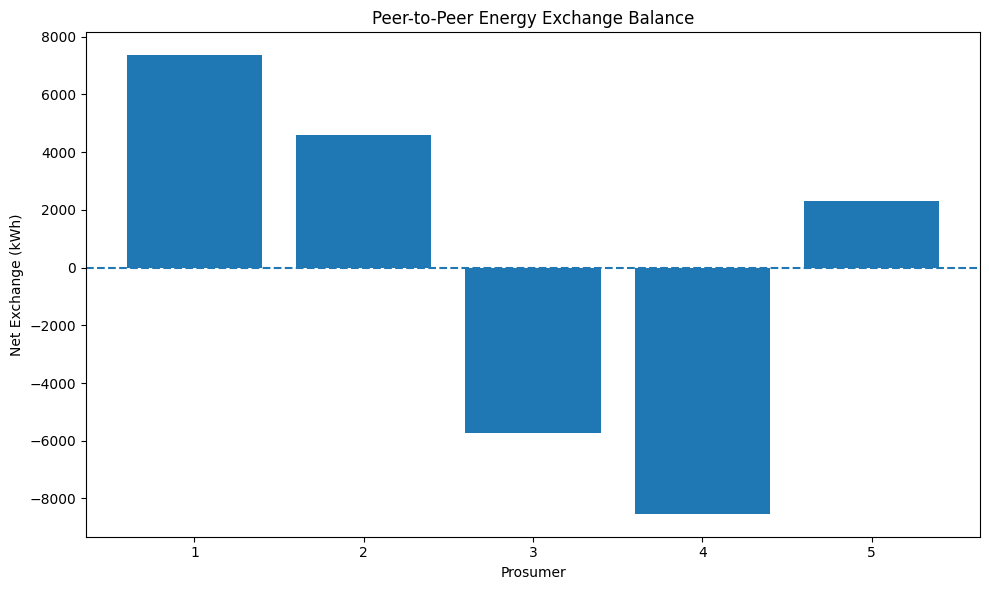

In [ ]:
# Detect number of prosumers automatically
import re

# Normalize columns (remove stray spaces)
df2.columns = df2.columns.str.strip()

# Ensure DateTime is a proper time index if present
if "DateTime" in df2.columns:
    df2["DateTime"] = pd.to_datetime(df2["DateTime"], errors="coerce")
    df2.set_index("DateTime", inplace=True)

# --- Bucket columns by type using robust regex (handles optional "model." prefix and spaces) ---
patterns = {
    "load":     r"^\s*P_Load\[\s*(\d+)\s*\]\s*$",
    "pv":       r"^\s*P_PV\[\s*(\d+)\s*\]\s*$",
    "peer_in":  r"^\s*P_Peer_in\[\s*(\d+)\s*\]\s*$",
    "peer_out": r"^\s*P_Peer_out\[\s*(\d+)\s*\]\s*$",
    "buy":      r"^\s*(?:model\.)?P_buy_grid\[\s*(\d+)\s*\]\s*$",
    "sell":     r"^\s*(?:model\.)?P_sell_grid\[\s*(\d+)\s*\]\s*$",
}

buckets = {k: {} for k in patterns}
for col in df2.columns:
    for key, pat in patterns.items():
        m = re.match(pat, col)
        if m:
            prosumer_id = int(m.group(1))
            buckets[key][prosumer_id] = col

# Determine the set of prosumers present in any of the buckets
prosumer_ids = sorted(set().union(*[set(d.keys()) for d in buckets.values()]))

# Helper to safely sum a column or return 0 if missing
def sum_col(key, pid):
    col = buckets[key].get(pid)
    if col is None:
        return 0.0
    return float(pd.to_numeric(df2[col], errors="coerce").fillna(0).sum())

# Build KPI table
missing_report = {}
rows = []
for pid in prosumer_ids:
    demand     = sum_col("load", pid)
    solar      = sum_col("pv", pid)
    purchased  = sum_col("buy", pid)
    sold       = sum_col("sell", pid)
    peer_in    = sum_col("peer_in", pid)
    peer_out   = sum_col("peer_out", pid)

    independence = 1 - (purchased / demand) if demand > 0 else 0.0
    peer_balance = peer_out - peer_in
    net_grid     = purchased - sold

    rows.append({
        "Prosumer": pid,
        "Demand": demand,
        "SolarProduction": solar,
        "Purchased": purchased,
        "Sold": sold,
        "NetGrid": net_grid,
        "Independence": independence,     # 0..1
        "PeerIn": peer_in,
        "PeerOut": peer_out,
        "PeerBalance": peer_balance       # >0 exporter to peers
    })

    # Track which expected columns are missing for this prosumer
    missing = [k for k in ["load","pv","buy","sell","peer_in","peer_out"] if pid not in buckets[k]]
    if missing:
        missing_report[pid] = missing

kpi_df = pd.DataFrame(rows).set_index("Prosumer").sort_index()
print("\n=== KPIs by prosumer ===")
print(kpi_df)

if missing_report:
    print("\n⚠️ Missing columns by prosumer (treated as 0 in KPIs):")
    for pid, keys in missing_report.items():
        print(f"  Prosumer {pid}: {', '.join(keys)}")

# Optional: export KPIs
# kpi_df.to_csv("kpis_by_prosumer.csv")

# ---------- Plots (matplotlib) ----------
# Note: no explicit colors/styles; each chart in its own figure.

# 1) Purchased vs Sold per prosumer
x = np.arange(len(kpi_df))
labels = kpi_df.index.astype(str)

plt.figure(figsize=(10,6))
plt.bar(x - 0.2, kpi_df["Purchased"].values, width=0.4, label="Purchased from Grid")
plt.bar(x + 0.2, kpi_df["Sold"].values, width=0.4, label="Sold to Grid")
plt.xticks(x, labels)
plt.xlabel("Prosumer")
plt.ylabel("Energy (kWh)")
plt.title("Grid Transactions per Prosumer")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Demand vs Solar Production per prosumer
plt.figure(figsize=(10,6))
plt.bar(x - 0.2, kpi_df["Demand"].values, width=0.4, label="Demand")
plt.bar(x + 0.2, kpi_df["SolarProduction"].values, width=0.4, label="Solar Production")
plt.xticks(x, labels)
plt.xlabel("Prosumer")
plt.ylabel("Energy (kWh)")
plt.title("Demand vs Solar Production per Prosumer")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Grid Independence (%) per prosumer
plt.figure(figsize=(10,6))
plt.bar(x, (kpi_df["Independence"].values * 100.0))
plt.xticks(x, labels)
plt.xlabel("Prosumer")
plt.ylabel("Independence (%)")
plt.title("Grid Independence per Prosumer")
plt.tight_layout()
plt.show()

# 4) Peer-to-Peer Net Exchange per prosumer
plt.figure(figsize=(10,6))
plt.bar(x, kpi_df["PeerBalance"].values)
plt.axhline(0, linestyle="--")
plt.xticks(x, labels)
plt.xlabel("Prosumer")
plt.ylabel("Net Exchange (kWh)")  # >0 means net exporter to peers
plt.title("Peer-to-Peer Energy Exchange Balance")
plt.tight_layout()
plt.show()

# Optimization with several batteries

In [40]:
# Load data
file_path = r"sampledata3.xlsx"
all_data = pd.read_excel(file_path, sheet_name=None)

# Extract data using Pandas
df_pv = all_data['PPV_capacity']
df_pl = all_data['PL']
df_buysell = all_data['buysell']
df_ess = all_data['ESS-Param']

# Extract date and time columns
date_pv = df_pv.iloc[:, 0].to_numpy().astype(str)
time_pv = df_pv.iloc[:, 1].to_numpy().astype(str)
datetime_pv = pd.to_datetime(
    pd.Series(date_pv).str.cat(pd.Series(time_pv), sep=' '),
    dayfirst=True
).to_numpy()


date_pl = df_pl.iloc[:, 0].to_numpy().astype(str)
time_pl = df_pl.iloc[:, 1].to_numpy().astype(str)
datetime_pl = pd.to_datetime(
    pd.Series(date_pl).str.cat(pd.Series(time_pl), sep=' '),
    dayfirst=True
).to_numpy()



date_buysell = df_buysell.iloc[:, 0].to_numpy().astype(str)
time_buysell = df_buysell.iloc[:, 1].to_numpy().astype(str)
datetime_buysell = pd.to_datetime(
    pd.Series(date_buysell).str.cat(pd.Series(time_buysell), sep=' '),
    dayfirst=True
).to_numpy()

# Extract data as numpy arrays
PPV_capacity_full = df_pv.iloc[:, 2:].to_numpy()
PLoad_full = df_pl.iloc[:, 2:].to_numpy()
Cbuysell_full = df_buysell.iloc[:, 2:].to_numpy()
Cbuy_full = Cbuysell_full[:, 0]
Csell_full = Cbuysell_full[:, 1]
ESSparam = df_ess.iloc[:, 1:].to_numpy()

    
#%%

# Define the date range for the simulation
start_date_str = '01.06.2024 00:00:00'
end_date_str = '30.06.2024 23:45:00'



# print(f"Default Start Date: {start_date_str}")
# print(f"Default End Date: {end_date_str}")

# # Ask user if they want to keep the default or input new dates
# response = input("Do you want to continue with these dates? (yes/no): ").strip().lower()

# if response == 'no':
#     start_date_str = input("Enter new start date (format DD.MM.YYYY HH:MM:SS): ").strip()
#     end_date_str = input("Enter new end date (format DD.MM.YYYY HH:MM:SS): ").strip()

# print(f"Using Start Date: {start_date_str}")
# print(f"Using End Date: {end_date_str}")

start_date = pd.to_datetime(start_date_str, dayfirst=True).to_numpy()
end_date = pd.to_datetime(end_date_str, dayfirst=True).to_numpy()


# Filter data based on the date range using numpy
mask_pv = (datetime_pv >= start_date) & (datetime_pv <= end_date)
mask_pl = (datetime_pl >= start_date) & (datetime_pl <= end_date)
mask_buysell = (datetime_buysell >= start_date) & (datetime_buysell <= end_date)


PPV_capacity = PPV_capacity_full[mask_pl]
PLoad = PLoad_full[mask_pl]
Cbuy = Cbuy_full[mask_buysell]
Csell = Csell_full[mask_buysell]
datetime_sim = datetime_pl[mask_pl]

# Ensure all data has the same number of time steps
num_time_steps = len(PLoad)
if PPV_capacity.shape[0] != num_time_steps or Cbuy.shape[0] != num_time_steps or Csell.shape[0] != num_time_steps:
    raise ValueError(
        "The number of time steps in PLoad, PPV_capacity, Cbuy, and Csell must be the same for the selected date range.")

# Calculate ΔT using numpy
time_diff_seconds = np.diff(datetime_sim).astype('timedelta64[s]').astype(np.float64)
time_diff_minutes = time_diff_seconds / 60
#indices = np.where(time_diff_minutes == 75)[0]
unique_dt_minutes = np.unique(time_diff_minutes)
#%%
# if unique_dt_minutes.size > 1:
#     raise ValueError("ΔT is not constant. The time step between data points must be constant.")
# elif unique_dt_minutes.size == 0:
#     raise ValueError("No time differences calculated. Check input data.")
# else:
#     dt_minutes_value = unique_dt_minutes[0]
ΔT = 0.25  #dt_minutes_value / 60

#%%

# Calculate the number of days
days = ((datetime_sim[-1] - datetime_sim[0]) / np.timedelta64(1, 'D')) + 1
days = int(days)  # optional: convert to integer
# Model Definition
nPlayers = PLoad.shape[1]
Thorizon = num_time_steps

# Initialize SOC
SOC_end_of_previous_period = {pl: ESSparam[3, pl - 1] for pl in range(1, nPlayers + 1)}
detailed_results = []
total_objective_value = 0
update_interval = 28800 # Update SOC every 288 time steps

#print(f"Solving for the period from {datetime_sim[0]} to {datetime_sim[-1]}...")

#%%
################## Indexes ####################################################################################

#for day in range(days):  # Loop over days 0,1,2,..., days-1
    
for chunk_start_time in range(0, Thorizon+1, update_interval):
    
    chunk_end_time = min(chunk_start_time + update_interval, Thorizon)
    
    print(f"Solving for time steps: {chunk_start_time} to {chunk_end_time}")
    
    
  
    
    model = ConcreteModel()  # Use ConcreteModel

    # Define sets
    model.PL = RangeSet(nPlayers)
    model.T = RangeSet(chunk_end_time - chunk_start_time)
    model.ESS1 = RangeSet(ESSparam.shape[0])

    # Define parameters using numpy arrays
    PLoad_chunk = PLoad[chunk_start_time:chunk_end_time]
    PPV_capacity_chunk = PPV_capacity[chunk_start_time:chunk_end_time]
    Cbuy_chunk = Cbuy[chunk_start_time:chunk_end_time]
    Csell_chunk = Csell[chunk_start_time:chunk_end_time]
    datetime_chunk = datetime_sim[chunk_start_time:chunk_end_time]
    
    
    model.PLs=Param(model.T,model.PL,initialize=lambda model,r,c:PLoad_chunk[r-1,c-1], within=Reals)
    model.PPV_capacitys=Param(model.T,model.PL,initialize=lambda model,r,c:PPV_capacity_chunk[r-1,c-1], within=Reals)
    model.Cbuys=Param(model.T,initialize=lambda model,r:Cbuy_chunk[r-1], within=Reals)
    model.Csells=Param(model.T,initialize=lambda model,r:Csell_chunk[r-1], within=Reals)
    model.ESSparams=Param(model.ESS1,model.PL,initialize=lambda model,r,c:ESSparam[r-1,c-1], within=Reals)
    

    # Variables
    model.P_ESS_s = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_ESS_ch = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_ESS_dch = Var(model.PL, model.T, within=NonNegativeReals)
    model.I_ESS_ch = Var(model.PL, model.T, within=Binary)
    model.I_ESS_dch = Var(model.PL, model.T, within=Binary)
    model.P_buy = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_sell = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_sell_grid = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_buy_grid = Var(model.PL, model.T, within=NonNegativeReals)
    model.P_peer = Var(model.PL, model.PL, model.T, within=NonNegativeReals)
    model.I_buy= Var(model.PL, model.T, within=Binary)
    model.I_sell = Var(model.PL, model.T, within=Binary)
    
    
    
    
    #    model.P_PV = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for charging battery
    #    model.P_PV_load = Var(model.PL, model.T, within=NonNegativeReals)  # PV used for direct load consumption



    # Constraints
    def SocESS_rule(model, PL, T):
        if T == 1:
            prev_SOC = SOC_end_of_previous_period[PL]
            return model.P_ESS_s[PL, T] == prev_SOC + ΔT * (
                model.ESSparams[model.ESS1.ord(1), PL] * model.P_ESS_ch[PL, T] - model.P_ESS_dch[PL, T] /
                model.ESSparams[model.ESS1.ord(1), PL])
        else:
            return model.P_ESS_s[PL, T] == (model.P_ESS_s[PL, T - 1]
                                            + ΔT * (model.ESSparams[model.ESS1.ord(1), PL] * model.P_ESS_ch[PL, T]
                                                    - model.P_ESS_dch[PL, T] / model.ESSparams[model.ESS1.ord(1), PL]))

    model.c_SOC = Constraint(model.PL, model.T, rule=SocESS_rule)



    def CapacitylimitESS1_rule(model, PL, T):
        return model.P_ESS_s[PL, T] <= model.ESSparams[model.ESS1.ord(3), PL]

    model.c92 = Constraint(model.PL, model.T, rule=CapacitylimitESS1_rule)



    def chargeESS1_rule(model, PL, T):
        return model.P_ESS_ch[PL, T] <= model.ESSparams[model.ESS1.ord(2), PL] * model.ESSparams[
            model.ESS1.ord(3), PL] * model.I_ESS_ch[PL, T]

    model.c42 = Constraint(model.PL, model.T, rule=chargeESS1_rule)
     
        
    
    def dischargeESS1_rule(model, PL, T):
        return model.P_ESS_dch[PL, T] <= model.ESSparams[model.ESS1.ord(2), PL] * model.ESSparams[
            model.ESS1.ord(3), PL] * model.I_ESS_dch[PL, T]

    model.c43 = Constraint(model.PL, model.T, rule=dischargeESS1_rule)



    def chargedischargeESS_rule(model, PL, T):
        return model.I_ESS_ch[PL, T] + model.I_ESS_dch[PL, T] <= 1

    model.c44 = Constraint(model.PL, model.T, rule=chargedischargeESS_rule)
    
    # def chargedischargelimit(model,PL):
    
    #         return sum( model.I_ESS_ch[PL,T]+model.I_ESS_dch[PL,T] for T in model.T) <=8
    
    # model.c45=Constraint(model.PL,rule=chargedischargelimit) #  ESS constraints



    def load_balance_rule(model, PL, T):
        return model.PLs[T, PL] + model.P_ESS_ch[PL, T] == model.PPV_capacitys[T, PL] + model.P_buy_grid[PL, T] - \
           model.P_sell_grid[PL, T] + model.P_ESS_dch[PL, T] + sum(
            model.P_peer[PL2, PL, T] - model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.c_balance = Constraint(model.PL, model.T, rule=load_balance_rule)
    
    def peer_flow_origin_rule(model, t):
        total_peer_in = sum(model.P_peer[pl2, pl, t] for pl in model.PL for pl2 in model.PL if pl2 != pl)
        total_peer_out = sum(model.P_peer[pl, pl2, t] for pl in model.PL for pl2 in model.PL if pl2 != pl)
        return total_peer_in == total_peer_out
    model.peer_origin = Constraint(model.T, rule=peer_flow_origin_rule)

    
     
    
    
    
    def peer_transfer_limit_rule(model, PL, T):
        return sum(model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL) <= np.maximum(0,
                                                                                 model.PPV_capacitys[T, PL] -
                                                                                 model.PLs[T, PL])

    model.c_peer = Constraint(model.PL, model.T, rule=peer_transfer_limit_rule)
    
#    def PV_utilization(model, PL, T):
#        return model.P_PV_ESS[PL, T] + model.P_PV_load[PL, T] == model.PPV_capacitys[T, PL]

#    model.c_PV_utilization = Constraint(model.PL, model.T, rule=PV_utilization)
#    def chargeESS2(model, PL, T):
#        return model.P_ESS_ch[PL, T] == model.P_PV_ESS[PL, T]  # Battery charges only from PV

#    model.c_ESS_PV_only = Constraint(model.PL, model.T, rule=chargeESS2)



    def enforce_battery_soc_limit_rule(model, PL, T):
        return model.P_ESS_s[PL, T]  >= model.ESSparams[model.ESS1.ord(4), PL]

    model.c21 = Constraint(model.PL, model.T, rule=enforce_battery_soc_limit_rule)



    def Pbuy11_rule(model, PL, T):
        return model.P_buy[PL, T] <= 200* model.I_buy[PL, T]

    model.c22 = Constraint(model.PL, model.T, rule=Pbuy11_rule)



    def Psell_balance(model, PL, T):
        return model.P_sell[PL, T] == model.P_sell_grid[PL, T]+sum(model.P_peer[PL, PL2, T] for PL2 in model.PL if PL2 != PL)

    model.psellbalance = Constraint(model.PL, model.T, rule=Psell_balance)


    def Pbuy_balance(model, PL, T):
        return model.P_buy[PL, T] == model.P_buy_grid[PL, T]+sum(model.P_peer[PL2, PL, T] for PL2 in model.PL if PL2 != PL)

    model.pbuybalance = Constraint(model.PL, model.T, rule=Pbuy_balance)



    def Psell11_rule(model, PL, T):
        return model.P_sell[PL, T] <= 100* model.I_sell[PL, T]

    model.c23 = Constraint(model.PL, model.T, rule=Psell11_rule)
    
    
    def Psellbuy(model, PL, T):
        return model.I_sell[PL, T]+model.I_buy[PL, T] <= 1

    model.csellbuy = Constraint(model.PL, model.T, rule=Psellbuy)
    
    
    



    # Objective Function
    def rule_OF(model):
        return sum(
            (model.Cbuys[t] * model.P_buy_grid[PL, t]
             - model.Csells[t] * model.P_sell_grid[PL, t])
            for t in model.T
            for PL in model.PL
        )

    model.Objective = Objective(rule=rule_OF, sense=minimize)
    
#      model.c_ESS_PV_only.deactivate()
    
    
    

    opt = SolverFactory('gurobi')
    #opt.options['TimeLimit'] = 100000  # Set a time limit of 300 seconds
    #opt.options['MIPGap'] = 0.01    # Set a MIP gap tolerance of 1%
    instance=model.create_instance() 
    # Solve the model

    opt.options['Threads'] = 28       
    opt.options['TimeLimit'] = 60000   # Set a time limit of 600 seconds (10 minutes)
    #    opt.options['MIPGap'] = 0.00005     # Allow 1% optimality gap
    #    opt.options['Heuristics'] = 0.3
    # Solve and measure time
    
    
    

    results = opt.solve(instance)
    results.write()

    total_objective_value += value(instance.Objective)
    
    # Prepare results for DataFrame 
    chunk_results_list = []
    # for t_index, t in enumerate(model.T):
    #     for pl_index, pl in enumerate(model.PL):
    #         chunk_results_list.append({
    #             "DateTime": datetime_chunk[t_index],
    #             "Time_Step": chunk_start_time + t_index + 1,  # Corrected time step
    #             "Prosumer": pl,
    #             "P_buy": value(instance.P_buy[pl, t]),
    #             "P_sell": value(instance.P_sell[pl, t]),
    #             "SOC": value(instance.P_ESS_s[pl, t]),
    #             "P_ESS_ch": value(instance.P_ESS_ch[pl, t]),
    #             "P_ESS_dch": value(instance.P_ESS_dch[pl, t]),
    #             "P_PV": value(instance.PPV_capacitys[t, pl]),
    #             "P_Peer_out": sum(value(instance.P_peer[pl, pl2, t]) for pl2 in model.PL if pl2 != pl),
    #             "P_Peer_in": sum(value(instance.P_peer[pl2, pl, t]) for pl2 in model.PL if pl2 != pl),
    #             "P_Load": value(instance.PLs[t, pl])
    #         })
    
    for t_index, t in enumerate(model.T):
        dt = pd.to_datetime(datetime_chunk[t_index])  # Convert to pandas Timestamp

        chunk_row = {
            "DateTime": dt,
            #"Date": dt.date(),  
            "Time_Step": chunk_start_time + t_index + 1,
        }
    
        for pl in model.PL:
            chunk_row[f"model.P_buy_grid[{pl}]"] = value(instance.P_buy_grid[pl, t])
            chunk_row[f"model.P_sell_grid[{pl}]"] = value(instance.P_sell_grid[pl, t])
            chunk_row[f"SOC[{pl}]"] = value(instance.P_ESS_s[pl, t])
            chunk_row[f"P_ESS_ch[{pl}]"] = value(instance.P_ESS_ch[pl, t])
            chunk_row[f"P_ESS_dch[{pl}]"] = value(instance.P_ESS_dch[pl, t])
            chunk_row[f"P_PV[{pl}]"] = value(instance.PPV_capacitys[t, pl])
            chunk_row[f"P_Peer_out[{pl}]"] = sum(value(instance.P_peer[pl, pl2, t]) for pl2 in model.PL if pl2 != pl)
            chunk_row[f"P_Peer_in[{pl}]"] = sum(value(instance.P_peer[pl2, pl, t]) for pl2 in model.PL if pl2 != pl)
            chunk_row[f"P_Load[{pl}]"] = value(instance.PLs[t, pl])
    
        chunk_results_list.append(chunk_row)

    
    
    
    
    
    
    
    
    # Convert chunk results to DataFrame and append
    chunk_results_df = pd.DataFrame(chunk_results_list)
    detailed_results.append(chunk_results_df)
#%%
    # Update SOC_end_of_previous_period 
    #SOC_end_of_day.update({(PL, day): value(instance.P_ESS_s[PL, Thorizon]) for PL in model.PL})
    SOC_end_of_previous_period.update( {pl: value(instance.P_ESS_s[pl, model.T.last()]) for pl in model.PL})
    print(f"SOC updated at time step: {chunk_end_time}")
    print(SOC_end_of_previous_period)

    
# Concatenate all chunk results
detailed_results_df = pd.concat(detailed_results, ignore_index=True)

# Convert results to a DataFrame and save to Excel
detailed_results_path = r"detailed_results.xlsx"
detailed_results_df.to_excel(detailed_results_path, index=False)

print(f"Detailed results for the period saved to: {detailed_results_path}")
print(f"Overall objective function value for the period: {total_objective_value:.2f}")

Solving for time steps: 0 to 2880
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 4268883.196289836
  Upper bound: 4268883.196289847
  Number of objectives: 1
  Number of constraints: 190080
  Number of variables: 216001
  Number of binary variables: 57600
  Number of integer variables: 57600
  Number of continuous variables: 158401
  Number of nonzeros: 662395
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Terminatio

In [41]:
print(detailed_results_df.columns)

Index(['DateTime', 'Time_Step', 'model.P_buy_grid[1]', 'model.P_sell_grid[1]',
       'SOC[1]', 'P_ESS_ch[1]', 'P_ESS_dch[1]', 'P_PV[1]', 'P_Peer_out[1]',
       'P_Peer_in[1]', 'P_Load[1]', 'model.P_buy_grid[2]',
       'model.P_sell_grid[2]', 'SOC[2]', 'P_ESS_ch[2]', 'P_ESS_dch[2]',
       'P_PV[2]', 'P_Peer_out[2]', 'P_Peer_in[2]', 'P_Load[2]',
       'model.P_buy_grid[3]', 'model.P_sell_grid[3]', 'SOC[3]', 'P_ESS_ch[3]',
       'P_ESS_dch[3]', 'P_PV[3]', 'P_Peer_out[3]', 'P_Peer_in[3]', 'P_Load[3]',
       'model.P_buy_grid[4]', 'model.P_sell_grid[4]', 'SOC[4]', 'P_ESS_ch[4]',
       'P_ESS_dch[4]', 'P_PV[4]', 'P_Peer_out[4]', 'P_Peer_in[4]', 'P_Load[4]',
       'model.P_buy_grid[5]', 'model.P_sell_grid[5]', 'SOC[5]', 'P_ESS_ch[5]',
       'P_ESS_dch[5]', 'P_PV[5]', 'P_Peer_out[5]', 'P_Peer_in[5]',
       'P_Load[5]'],
      dtype='object')


## Data treatment


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load and prepare ---
file_path = r"detailed_results.xlsx"
df2 = pd.read_excel(file_path, sheet_name=None)
df2 = pd.concat(df2.values(), ignore_index=True)

df2["DateTime"] = pd.to_datetime(df2["DateTime"])
df2.set_index("DateTime", inplace=True)

## Prosumer 1 plots

Grid independence: 25.12%


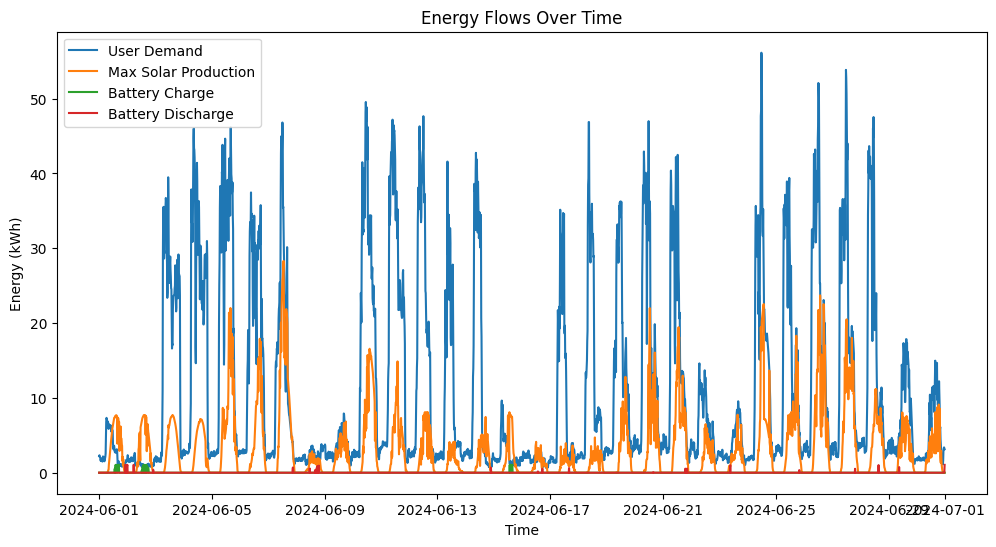

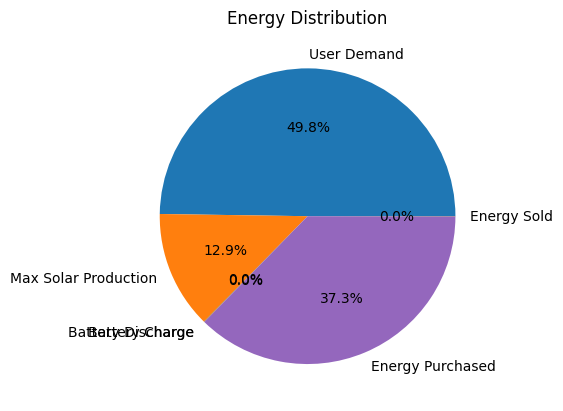

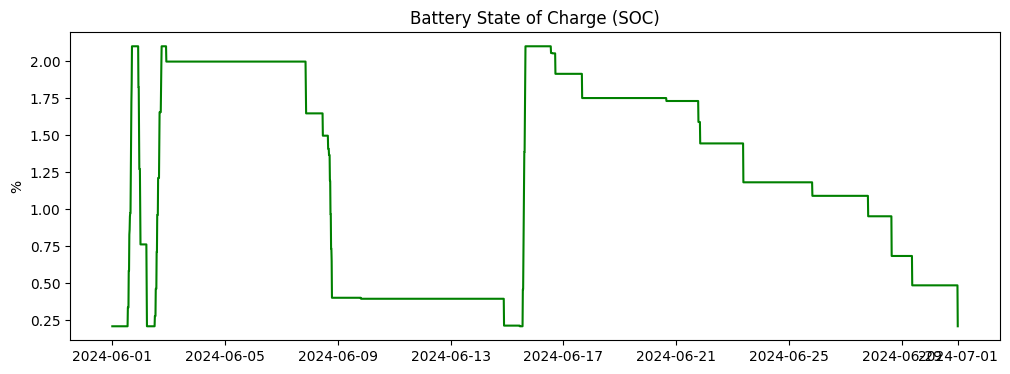

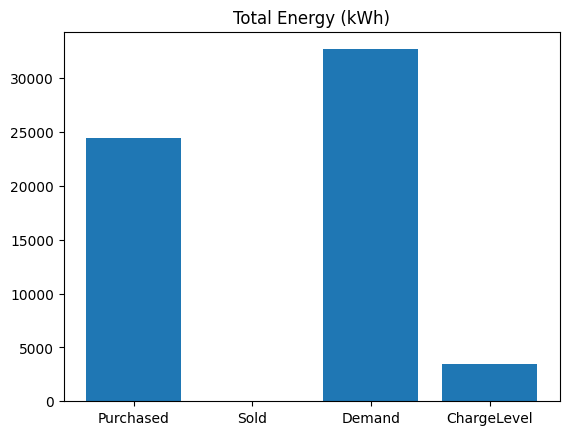

In [7]:
df2.rename(columns={
    "P_Load[1]": "UserDemand_1",
    "P_PV[1]": "MaxSolarProduction_1",
    "P_ESS_ch[1]": "BatteryCharge_1",
    "P_ESS_dch[1]": "BatteryDischarge_1",
    "SOC[1]": "ChargeLevel_1",
    "model.P_buy_grid[1]": "EnergyPurchased_1",
    "model.P_sell_grid[1]": "EnergySold_1"
}, inplace=True)

# --- KPIs ---
total_demand = df2["UserDemand_1"].sum()
total_purchased = df2["EnergyPurchased_1"].sum()
total_sold = df2["EnergySold_1"].sum()

independence = 1 - (total_purchased / total_demand)
print(f"Grid independence: {independence:.2%}")

# --- Plots ---
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2["UserDemand_1"], label="User Demand")
plt.plot(df2.index, df2["MaxSolarProduction_1"], label="Max Solar Production")
plt.plot(df2.index, df2["BatteryCharge_1"], label="Battery Charge")
plt.plot(df2.index, df2["BatteryDischarge_1"], label="Battery Discharge")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Energy Flows Over Time")
plt.show()

y = np.array([df2["UserDemand_1"], df2["MaxSolarProduction_1"], df2["BatteryCharge_1"], df2["BatteryDischarge_1"], df2["EnergyPurchased_1"], df2["EnergySold_1"]]).T
plt.pie(y.sum(axis=0), labels=["User Demand", "Max Solar Production", "Battery Charge", "Battery Discharge", "Energy Purchased", "Energy Sold"], autopct='%1.1f%%')
plt.title("Energy Distribution")
plt.show()

# Battery SOC
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["ChargeLevel_1"], color="green")
plt.title("Battery State of Charge (SOC)")
plt.ylabel("%")
plt.show()

# Total energy (bar chart)
totals = {
    "Purchased": total_purchased,
    "Sold": total_sold,
    "Demand": total_demand,
    "ChargeLevel": df2["ChargeLevel_1"].sum(),
}
plt.bar(totals.keys(), totals.values())
plt.title("Total Energy (kWh)")
plt.show()

...to be continued